In [1]:
import pandas as pd
import numpy as np
import pathlib
from lb2jpsil import lorentz
import joblib
from matplotlib import pyplot as plt

In [2]:
import matplotlib

font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = False

## Black and white?
black_and_white = False

In [4]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [5]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [6]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [7]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [8]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [9]:
## Create plots directory, if missing
repo_directory = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'
state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

plot_directory = (
    repo_directory + 'plots/'
    + 'selection_efficiencies/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [10]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

# Data prepping
## Import Monte Carlo data

In [11]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

In [12]:
def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [13]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [14]:
def norm(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

In [15]:
## Compute variables needed for Armenteros-Podolanski plots
def compute_momentum_asymmetry(
    df: pd.DataFrame, # The DataFrame that will be modified
    mother: str,      # Symbol of the mother: L or KS0
    daughter_1: str,  # Symbol of the conventionally positive daughter
    daughter_2: str,  # Symbol of the conventionally negative daughter
    prefix: str,      # Usually either 'MCTRUTH_' or 'DTF_FixJPsi_'
):

    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}{mother}_P{coord}'] = df[f'{prefix}{daughter_1}_P{coord}'] + df[f'{prefix}{daughter_2}_P{coord}']

    mother_uv = lorentz.unit_vector(np.array([df[f'{prefix}{mother}_PX'], df[f'{prefix}{mother}_PY'], df[f'{prefix}{mother}_PZ']]))
    part1_p = np.array([df[f'{prefix}{daughter_1}_PX'], df[f'{prefix}{daughter_1}_PY'], df[f'{prefix}{daughter_1}_PZ']])
    part2_p = np.array([df[f'{prefix}{daughter_2}_PX'], df[f'{prefix}{daughter_2}_PY'], df[f'{prefix}{daughter_2}_PZ']])

    part1_pL = scalar_product(part1_p, mother_uv)
    part2_pL = scalar_product(part2_p, mother_uv)

    part1_pT = part1_p - part1_pL * mother_uv
    part2_pT = part2_p - part2_pL * mother_uv

    part1_pT_norm = norm(part1_pT)
    part2_pT_norm = norm(part2_pT)

    df[f'{prefix}pL1'] = part1_pL
    df[f'{prefix}pL2'] = part2_pL
    df[f'{prefix}pT1'] = part1_pT_norm
    df[f'{prefix}pT2'] = part2_pT_norm
    
    df[f'{prefix}p_asymm'] = (df[f'{prefix}pL1'] - df[f'{prefix}pL2'])/(df[f'{prefix}pL1'] + df[f'{prefix}pL2'])

In [16]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [17]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')

df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

#del(df_reco, df_truth)
del(df_reco)

In [18]:
add_derived_variables(df_mc)

In [19]:
df_mc_norm = df_mc.loc[df_mc['MCTRUTH_L_ID']  == 3122].copy()
df_mc_bar = df_mc.loc[df_mc['MCTRUTH_L_ID']  == -3122].copy()

del(df_mc)

compute_momentum_asymmetry(df_mc_norm, 'L', 'p', 'pim', 'MCTRUTH_')
compute_momentum_asymmetry(df_mc_bar, 'L', 'pim', 'p', 'MCTRUTH_')
compute_momentum_asymmetry(df_mc_norm, 'L', 'p', 'pim', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_mc_bar, 'L', 'pim', 'p', 'DTF_FixJPsi_')

df_mc = pd.concat([df_mc_norm, df_mc_bar])

del(df_mc_norm, df_mc_bar)

/home/adegenna/lhcb-lb2jpsil/lb2jpsil/lorentz.py:39: RuntimeWarning: overflow encountered in square
  mag = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
/home/adegenna/apollo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


In [20]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,MCTRUTH_pT2,MCTRUTH_p_asymm,DTF_FixJPsi_L_PX,DTF_FixJPsi_L_PY,DTF_FixJPsi_L_PZ,DTF_FixJPsi_pL1,DTF_FixJPsi_pL2,DTF_FixJPsi_pT1,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,99.497910,0.717980,2514.137451,-1402.200317,3.465223e+04,2.987701e+04,4.894595e+03,159.749039,159.749100,0.718472
2,-0.4798,-0.7758,18.706800,-785.810974,-591.072998,5157.507812,-5172.310059,-3904.530029,34147.730469,-470.119995,...,48.847118,0.849286,-5741.102539,-4314.616699,3.757989e+04,3.540801e+04,2.851951e+03,89.609009,89.609032,0.850917
3,1.6829,-2.2522,-36.520901,94.709503,-270.525391,3823.881348,5635.350098,-15984.469727,230495.453125,604.909973,...,87.610291,0.780177,6305.069336,-18263.478516,2.624094e+05,2.329924e+05,3.012738e+04,268.224182,268.223846,0.770999
7,-0.0398,-0.0673,5.665700,-249.259796,-139.331497,4827.745117,-1509.760010,-841.409973,29903.369141,-513.349976,...,42.006252,0.527719,-2036.070435,-1135.990234,3.939089e+04,3.014402e+04,9.315809e+03,42.377007,42.377182,0.527833
10,1.6627,-0.7055,36.293701,552.021912,-324.502899,5087.420898,6835.500000,-4024.709961,62359.808594,513.340027,...,48.738144,0.849341,7603.650391,-4472.518555,6.976765e+04,6.505972e+04,5.263425e+03,139.727448,139.728439,0.850307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366385,1.4790,1.6164,117.685402,-145.718094,413.124207,5320.206543,-614.000000,1525.500000,20376.880859,-94.570000,...,93.880417,-0.626835,-685.289490,1921.372437,2.426446e+04,4.501617e+03,1.984844e+04,90.401405,90.401573,-0.630258
366389,1.3007,0.2778,-21.330700,183.874298,169.122696,4690.991699,1534.709961,1412.310059,40749.351562,497.239990,...,64.903572,-0.553833,-273813.687500,-218378.093750,-7.062924e+06,1.698578e+06,5.373024e+06,100848.273438,100848.296875,-0.519606
366392,-0.5103,1.2180,21.928400,-148.940399,123.715599,7319.557129,-1238.500000,978.909973,57653.351562,-45.599998,...,66.776886,-0.826449,-11736.989258,9726.655273,5.853699e+05,-1.689302e+04,6.024614e+05,174.492188,174.493271,-1.057698


# Define selection cuts

## Prefilters

In [21]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [22]:
pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

In [23]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

## DTF convergency requirement

In [24]:
dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 0.0

## $B^0$ invariant mass veto

In [25]:
b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

## Armenteros-Podolanski veto

In [26]:
armenteros_cuts = (abs(df_mc['DTF_FixJPsi_p_asymm']) > 0.5)

## HBDT cut

In [27]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [28]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [29]:
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
df_mc['HBDT'] = mc_predicted
hbdt_cuts = df_mc['HBDT'] > hard_threshold

# Efficiencies

In [30]:
edges_zvtx = np.linspace(5500, 7600, 17)
bins_zvtx = [(l,r) for l, r in zip(edges_zvtx[:-1], edges_zvtx[1:])]
bins_zvtx

[(5500.0, 5631.25),
 (5631.25, 5762.5),
 (5762.5, 5893.75),
 (5893.75, 6025.0),
 (6025.0, 6156.25),
 (6156.25, 6287.5),
 (6287.5, 6418.75),
 (6418.75, 6550.0),
 (6550.0, 6681.25),
 (6681.25, 6812.5),
 (6812.5, 6943.75),
 (6943.75, 7075.0),
 (7075.0, 7206.25),
 (7206.25, 7337.5),
 (7337.5, 7468.75),
 (7468.75, 7600.0)]

In [31]:
all_data_selection = ~df_mc['MCTRUTH_Lb_ENDVERTEX_Z'].isna()

In [32]:
def efficiencies(df: pd.DataFrame, base_data_selection: pd.Series, sel_to_pass: pd.Series) -> pd.DataFrame:
    df_eff = pd.DataFrame(columns=['bin_midpoint', 'efficiency'])
    
    for z_bin in bins_zvtx:
        eff_dict = {}
        
        bin_sel = (df['MCTRUTH_L_ENDVERTEX_Z'] >= z_bin[0]) & (df['MCTRUTH_L_ENDVERTEX_Z'] < z_bin[1])
        
        base_event_number = sum(bin_sel & base_data_selection)
        pass_event_number = sum(bin_sel & base_data_selection & sel_to_pass)
        
        eff_dict['bin_midpoint'] = sum(z_bin)/2
        eff_dict['efficiency'] = pass_event_number / base_event_number
        
        df_eff = df_eff.append(eff_dict, ignore_index=True)
        
    return df_eff

In [33]:
base_sel = all_data_selection
new_sel = pre_selection_cuts

df_eff_prefilter = efficiencies(df_mc, base_sel, new_sel)

In [34]:
base_sel = all_data_selection & pre_selection_cuts
new_sel = dtf_success_cuts

df_eff_dtf = efficiencies(df_mc, base_sel, new_sel)

In [35]:
base_sel = all_data_selection & pre_selection_cuts & dtf_success_cuts
new_sel = b0_veto_cuts

df_eff_b0veto = efficiencies(df_mc, base_sel, new_sel)

In [36]:
base_sel = all_data_selection & pre_selection_cuts & dtf_success_cuts & b0_veto_cuts
new_sel = armenteros_cuts

df_eff_armenteros = efficiencies(df_mc, base_sel, new_sel)

In [37]:
base_sel = all_data_selection & pre_selection_cuts & dtf_success_cuts & b0_veto_cuts & armenteros_cuts
new_sel = hbdt_cuts

df_eff_hbdt = efficiencies(df_mc, base_sel, new_sel)

In [38]:
base_sel = all_data_selection
new_sel = pre_selection_cuts & dtf_success_cuts & b0_veto_cuts & armenteros_cuts & hbdt_cuts

df_eff_total = efficiencies(df_mc, base_sel, new_sel)

In [39]:
## Parameterized lines
dashdotdot = (0, (3, 1, 1, 1, 1, 1))
dashdashdot = (0, (3, 1, 3, 1, 1, 1))

In [40]:
eff_color = 'black'

if black_and_white:
    total_color = 'black'
else:
    total_color = 'tab:orange'

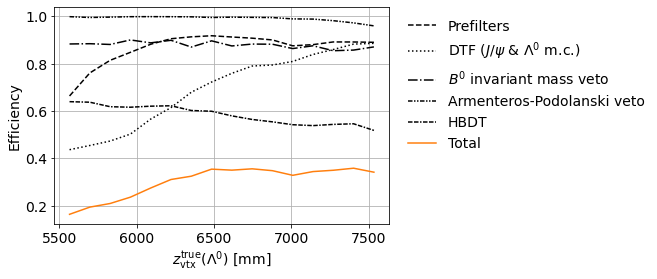

In [41]:
plt.plot(df_eff_prefilter['bin_midpoint'], df_eff_prefilter['efficiency'], color=eff_color, linestyle='dashed', label='Prefilters')
plt.plot(df_eff_dtf['bin_midpoint'], df_eff_dtf['efficiency'], color=eff_color, linestyle='dotted', label='DTF ($J/\psi$ & $\Lambda^0$ m.c.)')
plt.plot(df_eff_b0veto['bin_midpoint'], df_eff_b0veto['efficiency'], color=eff_color, linestyle='dashdot', label='$B^0$ invariant mass veto')
plt.plot(df_eff_armenteros['bin_midpoint'], df_eff_armenteros['efficiency'], color=eff_color, linestyle=dashdotdot, label='Armenteros-Podolanski veto')
plt.plot(df_eff_hbdt['bin_midpoint'], df_eff_hbdt['efficiency'], color=eff_color, linestyle=dashdashdot, label='HBDT')
plt.plot(df_eff_total['bin_midpoint'], df_eff_total['efficiency'], color=total_color, linestyle='solid', label='Total')


plt.grid()
plt.xlabel(r'$z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]')
plt.ylabel("Efficiency")

if show_titles:
    plt.title("Selection efficiencies")

plt.legend(frameon=False, bbox_to_anchor=(1.02, 1))

if save_plots:
    plt.savefig(plot_directory + 'selection_efficiencies' + '.pdf', bbox_inches = 'tight')
    plt.savefig(plot_directory + 'selection_efficiencies' + '.png', bbox_inches = 'tight', dpi=150)

plt.show()

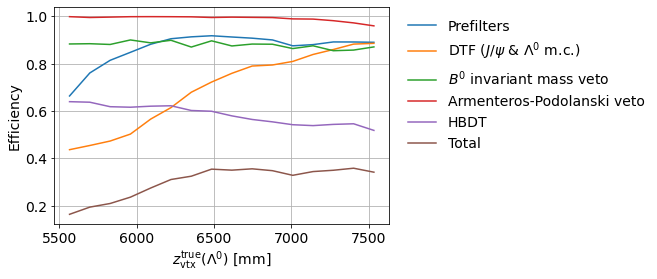

In [42]:
plt.plot(df_eff_prefilter['bin_midpoint'], df_eff_prefilter['efficiency'], label='Prefilters')
plt.plot(df_eff_dtf['bin_midpoint'], df_eff_dtf['efficiency'], label='DTF ($J/\psi$ & $\Lambda^0$ m.c.)')
plt.plot(df_eff_b0veto['bin_midpoint'], df_eff_b0veto['efficiency'], label='$B^0$ invariant mass veto')
plt.plot(df_eff_armenteros['bin_midpoint'], df_eff_armenteros['efficiency'], label='Armenteros-Podolanski veto')
plt.plot(df_eff_hbdt['bin_midpoint'], df_eff_hbdt['efficiency'], label='HBDT')
plt.plot(df_eff_total['bin_midpoint'], df_eff_total['efficiency'], label='Total')


plt.grid()
plt.xlabel(r'$z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]')
plt.ylabel("Efficiency")

if show_titles:
    plt.title("Selection efficiencies")

plt.legend(frameon=False, bbox_to_anchor=(1.02, 1))

if save_plots:
    plt.savefig(plot_directory + 'selection_efficiencies_color' + '.pdf', bbox_inches = 'tight')
    plt.savefig(plot_directory + 'selection_efficiencies_color' + '.png', bbox_inches = 'tight', dpi=150)

plt.show()